In [ ]:
# Install dependencies (uncomment if not installed)
# pip install opencv-python mediapipe numpy

import cv2
import numpy as np
import mediapipe as mp

# Constants for face landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# MediaPipe face mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Start video capture
cap = cv2.VideoCapture(0)

def get_landmark_coords(landmarks, frame_shape):
    h, w = frame_shape
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, frame_shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], frame_shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], frame_shape)[0],
    ], dtype="double")

    # 3D model points
    model_points = np.array([
        (0.0, 0.0, 0.0),       # Nose tip
        (0.0, -63.6, -12.5),   # Chin
        (-43.3, 32.7, -26),    # Left eye
        (43.3, 32.7, -26),     # Right eye
        (-28.9, -28.9, -24.1), # Left Mouth
        (28.9, -28.9, -24.1)   # Right mouth
    ])

    focal_length = frame_shape[1]
    center = (frame_shape[1] / 2, frame_shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion

    success, rotation_vector, translation_vector = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs
    )

    return rotation_vector, translation_vector

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle  # degrees

def classify_gaze(yaw, eye_angle):
    combined = 0.7 * yaw + 0.3 * eye_angle

    if combined < -15:
        return "Looking Left"
    elif combined > 15:
        return "Looking Right"
    else:
        return "Looking Center"

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark
        shape = frame.shape

        # Get rotation vector (yaw, pitch, roll)
        rot_vec, trans_vec = compute_head_pose(landmarks, shape)

        # Convert rotation vector to angles
        rot_matrix, _ = cv2.Rodrigues(rot_vec)
        angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
        yaw = angles[1]  # Yaw (left/right)

        # Get eye positions
        left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
        right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]

        # Estimate eye direction
        eye_angle = get_gaze_direction(left_eye, right_eye)

        # Final classification
        gaze_label = classify_gaze(yaw, eye_angle)

        # Draw feedback
        cv2.putText(frame, gaze_label, (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

        # Draw facial landmarks
        mp_drawing.draw_landmarks(
            frame,
            results.multi_face_landmarks[0],
            mp_face_mesh.FACEMESH_CONTOURS
        )

    cv2.imshow("Head Pose and Gaze Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
# 🧼 Clean reinstall of numpy and dependencies to fix compatibility issues
!pip uninstall -y numpy
!pip install numpy==1.23.5 --no-binary :all:

# Install required dependencies
!pip install opencv-python-headless==4.7.0.72 mediapipe --quiet



Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 req

^C


## Head Pose Only

Saving looking left.jpg to looking left (1).jpg


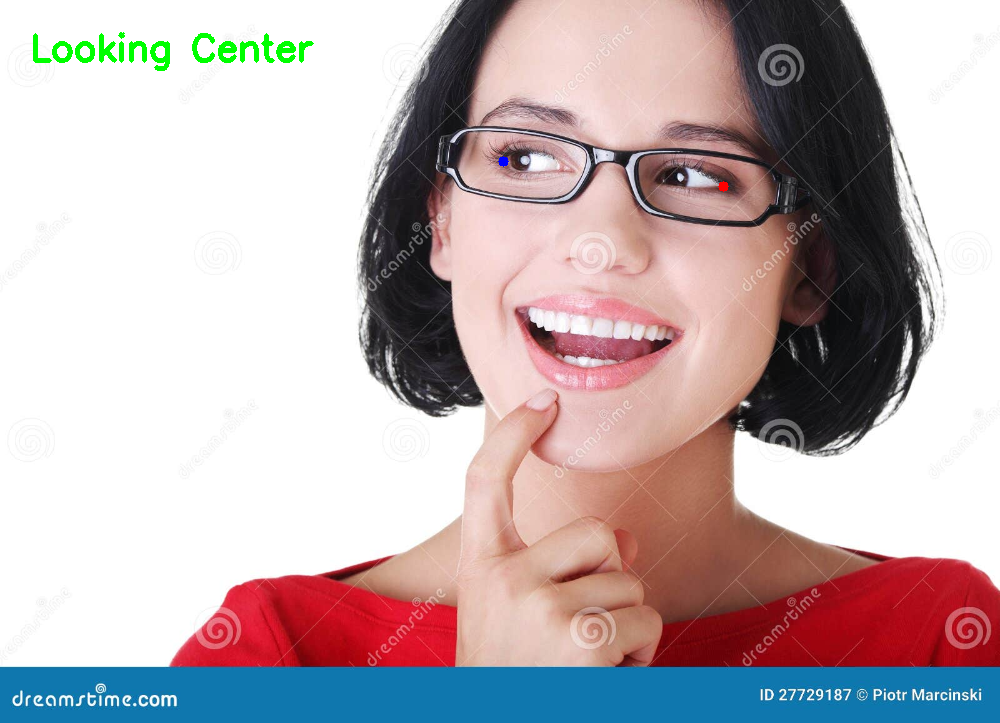

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

# Resize if the image is too large
if image.shape[1] > 1000:
    image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

# Constants for landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# Initialize MediaPipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Process the uploaded image
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb)

# Functions to extract landmarks and compute head pose
def get_landmark_coords(landmarks, shape):
    h, w, _ = shape  # Fix: unpack the image shape correctly (height, width, channels)
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], shape)[0],
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),       # Nose tip
        (0.0, -63.6, -12.5),   # Chin
        (-43.3, 32.7, -26),    # Left eye
        (43.3, 32.7, -26),     # Right eye
        (-28.9, -28.9, -24.1), # Left Mouth
        (28.9, -28.9, -24.1)   # Right mouth
    ])

    focal_length = shape[1]
    center = (shape[1] / 2, shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))  # Assuming no lens distortion

    success, rot_vec, trans_vec = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs
    )

    return rot_vec, trans_vec

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle

def classify_gaze(yaw, eye_angle):
    # Combining both yaw (head pose) and eye gaze angle
    if eye_angle < -10:
        gaze_label = "Looking Left"
    elif eye_angle > 10:
        gaze_label = "Looking Right"
    else:
        if yaw < -15:
            gaze_label = "Looking Left (Head)"
        elif yaw > 15:
            gaze_label = "Looking Right (Head)"
        else:
            gaze_label = "Looking Center"
    return gaze_label

# If a face is detected
if results.multi_face_landmarks:
    shape = image.shape
    landmarks = results.multi_face_landmarks[0].landmark

    # Get head pose (yaw)
    rot_vec, _ = compute_head_pose(landmarks, shape)
    rot_matrix, _ = cv2.Rodrigues(rot_vec)  # Correct unpacking
    angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
    yaw = angles[1]  # Yaw angle

    # Get eye positions
    left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
    right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]

    # Estimate eye gaze direction
    eye_angle = get_gaze_direction(left_eye, right_eye)

    # Classify gaze
    gaze_label = classify_gaze(yaw, eye_angle)

    # Annotate the image with gaze label
    cv2.putText(image, gaze_label, (30, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 3)

    # Draw eye landmarks
    cv2.circle(image, left_eye, 5, (255, 0, 0), -1)
    cv2.circle(image, right_eye, 5, (0, 0, 255), -1)

    # Show the processed image in Colab
    cv2_imshow(image)
else:
    print("No face detected.")

## Eye Gaze Only

Saving looking left.jpg to looking left (2).jpg
Gaze Direction: Looking Right


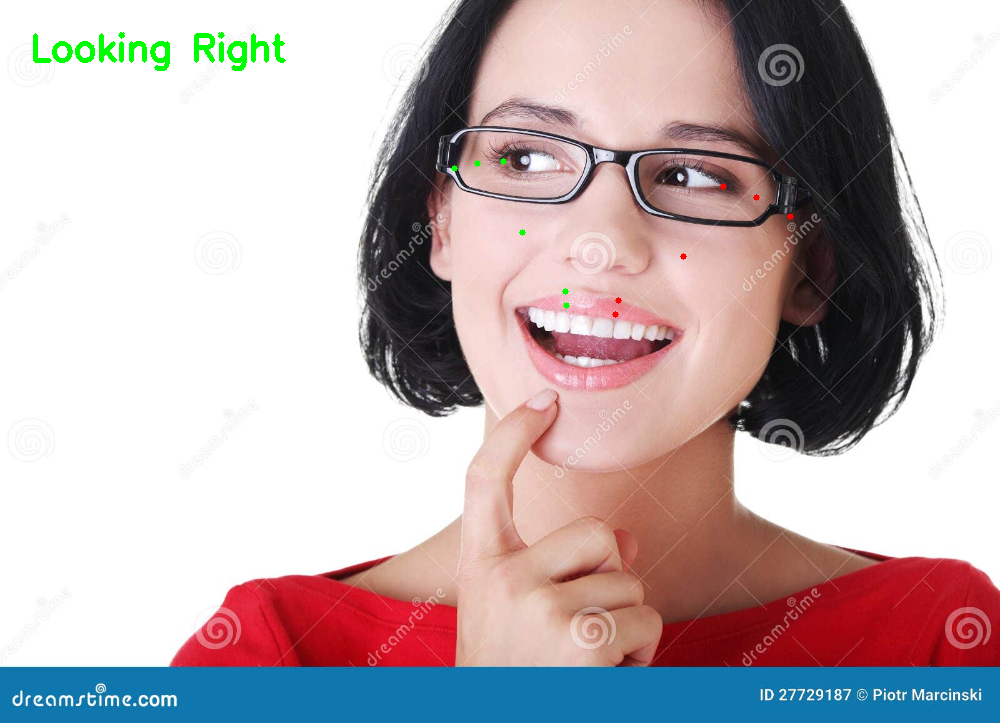

In [ ]:
# Install required dependencies
# !pip install opencv-python-headless==4.7.0.72 mediapipe --quiet

import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

# Resize if the image is too large
if image.shape[1] > 1000:
    image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

# Initialize MediaPipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Constants for eye landmarks
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263

# Process the uploaded image
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = face_mesh.process(rgb)

# Function to get the eye landmarks coordinates
def get_eye_landmark_coords(landmarks, shape):
    h, w, _ = shape  # Fix: unpack the image shape correctly (height, width, channels)
    left_eye = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks[LEFT_EYE_IDX:LEFT_EYE_IDX + 6]]
    right_eye = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks[RIGHT_EYE_IDX:RIGHT_EYE_IDX + 6]]
    return left_eye, right_eye

# Function to determine gaze direction based on the eye landmarks
def determine_gaze_direction(left_eye, right_eye):
    # Average x positions of the left and right eye
    left_eye_x = np.mean([point[0] for point in left_eye])
    right_eye_x = np.mean([point[0] for point in right_eye])

    # Calculate the horizontal difference between the eyes
    horizontal_diff = right_eye_x - left_eye_x

    # Classify gaze direction
    if horizontal_diff > 20:  # Looking right
        return "Looking Right"
    elif horizontal_diff < -20:  # Looking left
        return "Looking Left"
    else:  # Looking center
        return "Looking Center"

# If a face is detected
if results.multi_face_landmarks:
    shape = image.shape
    landmarks = results.multi_face_landmarks[0].landmark

    # Get the eye landmarks for both left and right eyes
    left_eye, right_eye = get_eye_landmark_coords(landmarks, shape)

    # Determine gaze direction based on eye landmarks
    gaze_direction = determine_gaze_direction(left_eye, right_eye)

    # Print the gaze direction
    print(f"Gaze Direction: {gaze_direction}")

    # Draw circles on the eye landmarks
    for point in left_eye:
        cv2.circle(image, point, 3, (0, 255, 0), -1)  # Green for left eye landmarks
    for point in right_eye:
        cv2.circle(image, point, 3, (0, 0, 255), -1)  # Red for right eye landmarks

    # Annotate the image with gaze direction
    cv2.putText(image, gaze_direction, (30, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 3)

    # Show the processed image with tracked eye landmarks
    cv2_imshow(image)
else:
    print("No face detected.")


## Eye Gaze and Head Pose

Saving Alexandra Daddario_1.jpg to Alexandra Daddario_1 (2).jpg
Saving andSam2.jpg to andSam2.jpg
Saving carv2.jpg to carv2 (2).jpg
Saving chopra.jpg to chopra (3).jpg
Saving claire.jpg to claire (2).jpg
Saving liz Olsen.webp to liz Olsen (3).webp
Saving looking left.jpg to looking left (3).jpg
Saving looking right.webp to looking right (3).webp
Saving looking up.webp to looking up (3).webp
Saving rock.jpg to rock (2).jpg

Processing: Alexandra Daddario_1 (2).jpg


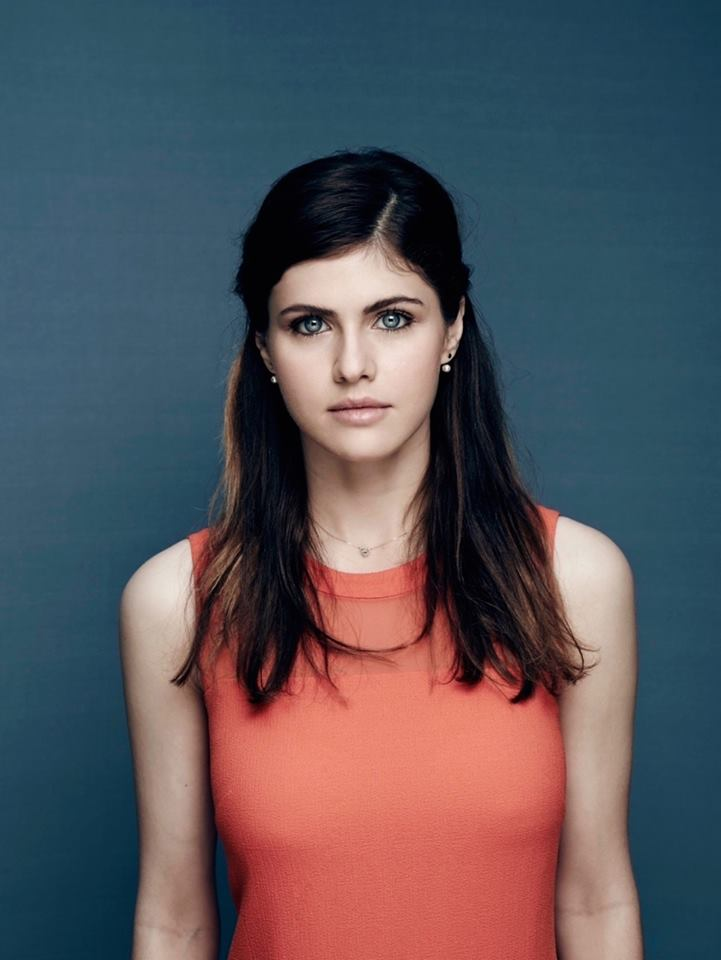

Gaze Direction: Looking Center / Facing Center
Attention Score: 100%

Processing: andSam2.jpg


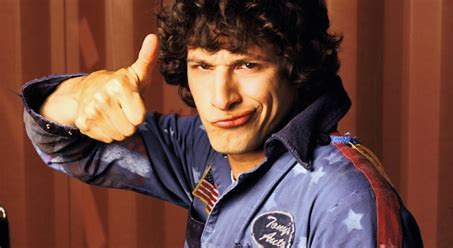

Gaze Direction: Looking Center / Facing Right
Attention Score: 50%

Processing: carv2 (2).jpg


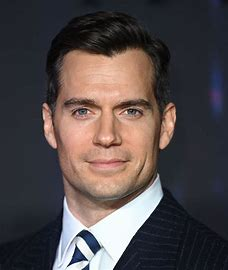

Gaze Direction: Looking Center / Facing Center
Attention Score: 100%

Processing: chopra (3).jpg


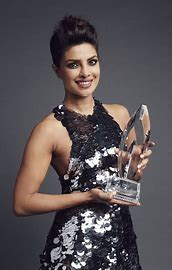

Gaze Direction: Looking Center / Facing Left
Attention Score: 50%

Processing: claire (2).jpg


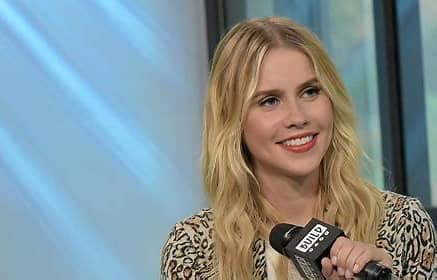

Gaze Direction: Looking Left / Facing Left
Attention Score: 25%

Processing: liz Olsen (3).webp


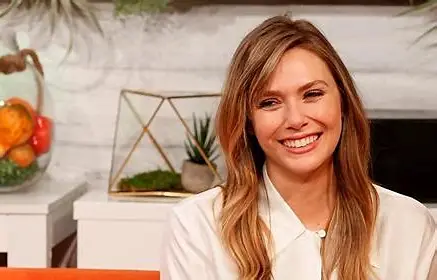

Gaze Direction: Looking Left / Facing Right
Attention Score: 60%

Processing: looking left (3).jpg


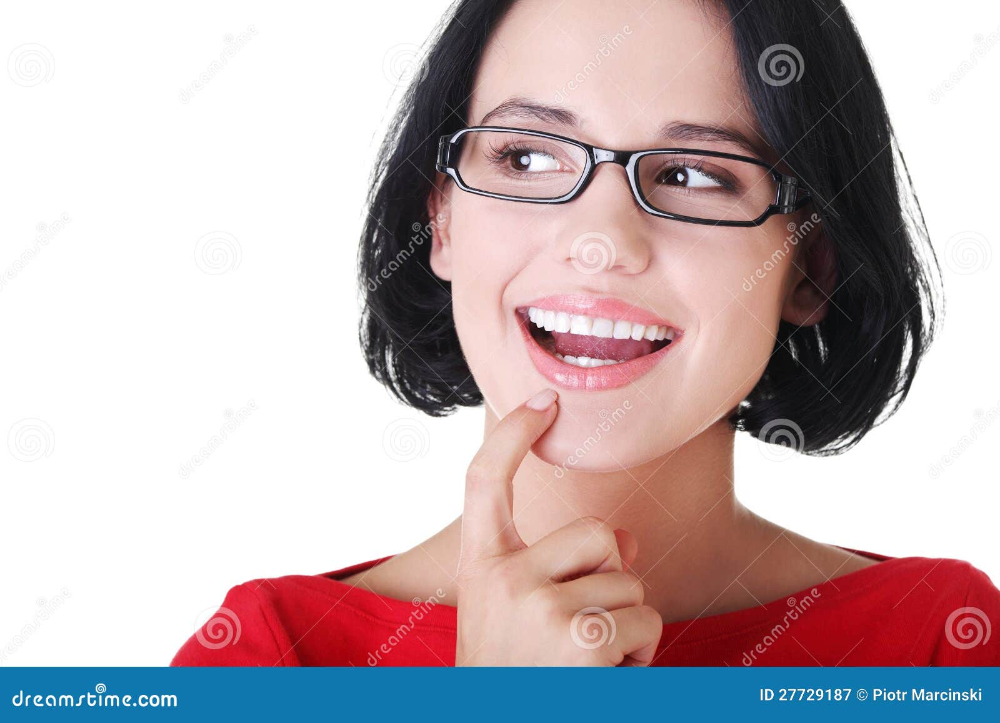

Gaze Direction: Looking Center / Facing Right
Attention Score: 50%

Processing: looking right (3).webp


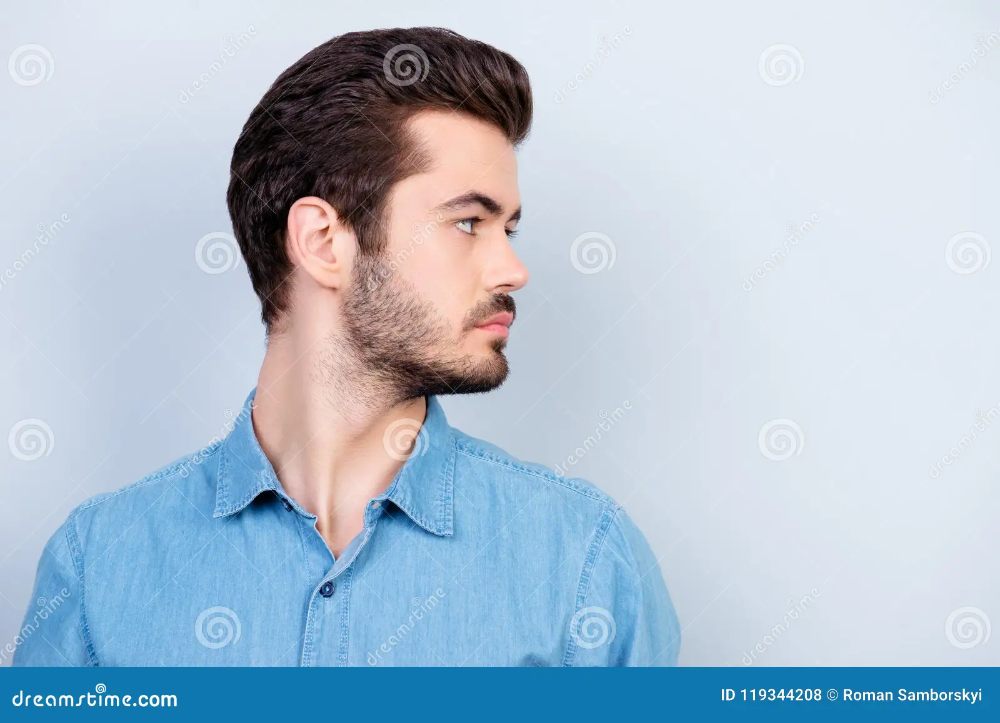

Gaze Direction: Looking Right / Facing Right
Attention Score: 25%

Processing: looking up (3).webp


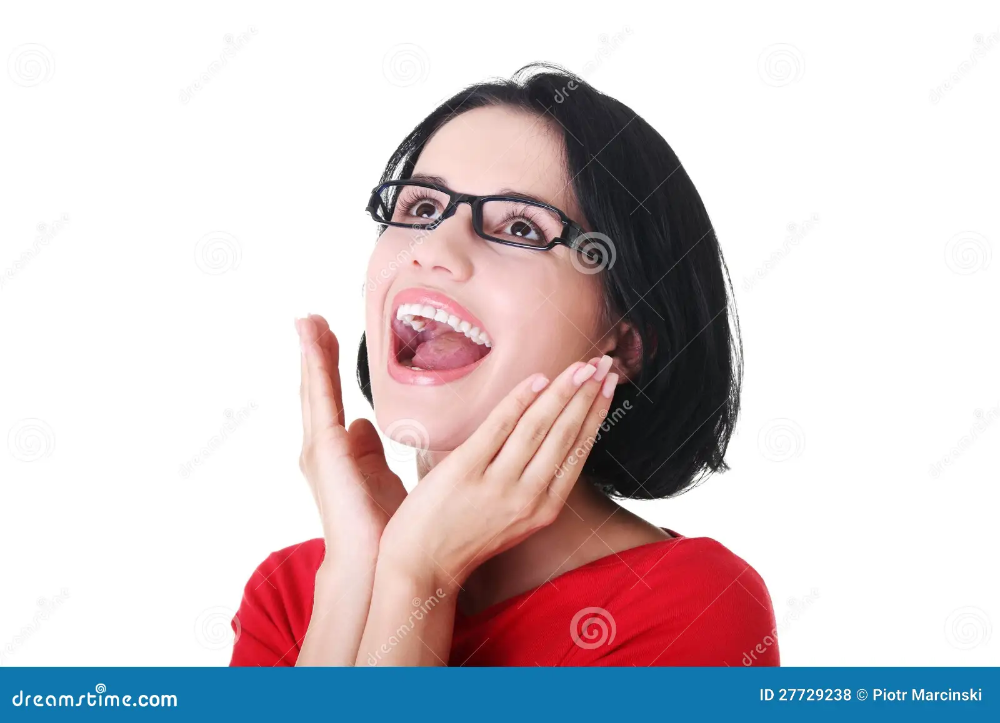

Gaze Direction: Looking Right / Facing Right
Attention Score: 25%

Processing: rock (2).jpg


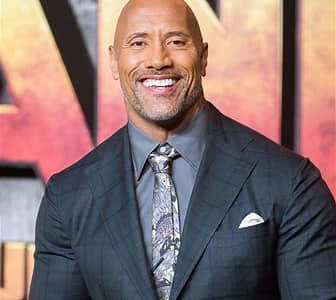

Gaze Direction: Looking Center / Facing Center
Attention Score: 100%


In [ ]:
# Install if not already
# !pip install opencv-python-headless==4.7.0.72 mediapipe --quiet

import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload multiple images
uploaded = files.upload()
image_paths = list(uploaded.keys())

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# Helper functions
def get_landmark_coords(landmarks, shape):
    h, w, _ = shape
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], shape)[0],
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (0.0, -63.6, -12.5),
        (-43.3, 32.7, -26),
        (43.3, 32.7, -26),
        (-28.9, -28.9, -24.1),
        (28.9, -28.9, -24.1)
    ])

    focal_length = shape[1]
    center = (shape[1] / 2, shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    success, rot_vec, trans_vec = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    return rot_vec, trans_vec

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle

def describe_gaze(yaw, eye_angle):
    head_dir = "Facing Center"
    eye_dir = "Looking Center"
    if yaw < -10: head_dir = "Facing Left"
    elif yaw > 10: head_dir = "Facing Right"
    if eye_angle < -10: eye_dir = "Looking Left"
    elif eye_angle > 10: eye_dir = "Looking Right"
    return f"{eye_dir} / {head_dir}"

def smart_attention_score(yaw, eye_angle):
    yaw_abs = abs(yaw)
    eye_abs = abs(eye_angle)
    same_dir = (yaw > 10 and eye_angle > 10) or (yaw < -10 and eye_angle < -10)
    opposite_dir = (yaw > 10 and eye_angle < -10) or (yaw < -10 and eye_angle > 10)

    if yaw_abs < 10 and eye_abs < 10:
        return 100
    elif yaw_abs < 10 and eye_abs < 20:
        return 75
    elif yaw_abs < 10:
        return 50
    elif opposite_dir:
        return 60
    elif same_dir:
        return 25
    else:
        return 50

# Process all images
for image_path in image_paths:
    print(f"\nProcessing: {image_path}")
    image = cv2.imread(image_path)
    if image.shape[1] > 1000:
        image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        shape = image.shape
        landmarks = results.multi_face_landmarks[0].landmark

        # Head pose
        rot_vec, _ = compute_head_pose(landmarks, shape)
        rot_matrix, _ = cv2.Rodrigues(rot_vec)
        angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
        yaw = angles[1]

        # Eyes
        left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
        right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]
        eye_angle = get_gaze_direction(left_eye, right_eye)

        # Output results
        gaze_label = describe_gaze(yaw, eye_angle)
        attention = smart_attention_score(yaw, eye_angle)

        # Display image only (no text on it)
        cv2_imshow(image)

        # Print the results below
        print(f"Gaze Direction: {gaze_label}")
        print(f"Attention Score: {attention}%")

    else:
        print("No face detected.")


## With Annotations on images

In [ ]:
# Install if not already
# !pip install opencv-python-headless==4.7.0.72 mediapipe --quiet

import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload multiple images
uploaded = files.upload()
image_paths = list(uploaded.keys())

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

# Landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# Helper functions
def get_landmark_coords(landmarks, shape):
    h, w, _ = shape
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], shape)[0],
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (0.0, -63.6, -12.5),
        (-43.3, 32.7, -26),
        (43.3, 32.7, -26),
        (-28.9, -28.9, -24.1),
        (28.9, -28.9, -24.1)
    ])

    focal_length = shape[1]
    center = (shape[1] / 2, shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    success, rot_vec, trans_vec = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    return rot_vec, trans_vec

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle

def describe_gaze(yaw, eye_angle):
    head_dir = "Facing Center"
    eye_dir = "Looking Center"
    if yaw < -10: head_dir = "Facing Left"
    elif yaw > 10: head_dir = "Facing Right"
    if eye_angle < -10: eye_dir = "Looking Left"
    elif eye_angle > 10: eye_dir = "Looking Right"
    return f"{eye_dir} / {head_dir}"

def smart_attention_score(yaw, eye_angle):
    yaw_abs = abs(yaw)
    eye_abs = abs(eye_angle)
    same_dir = (yaw > 10 and eye_angle > 10) or (yaw < -10 and eye_angle < -10)
    opposite_dir = (yaw > 10 and eye_angle < -10) or (yaw < -10 and eye_angle > 10)

    if yaw_abs < 10 and eye_abs < 10:
        return 100
    elif yaw_abs < 10 and eye_abs < 20:
        return 75
    elif yaw_abs < 10:
        return 50
    elif opposite_dir:
        return 60
    elif same_dir:
        return 25
    else:
        return 50

# Process all images
for image_path in image_paths:
    print(f"Processing: {image_path}")
    image = cv2.imread(image_path)
    if image.shape[1] > 1000:
        image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        shape = image.shape
        landmarks = results.multi_face_landmarks[0].landmark

        # Head pose
        rot_vec, _ = compute_head_pose(landmarks, shape)
        rot_matrix, _ = cv2.Rodrigues(rot_vec)
        angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
        yaw = angles[1]

        # Eyes
        left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
        right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]
        eye_angle = get_gaze_direction(left_eye, right_eye)

        # Annotate
        gaze_label = describe_gaze(yaw, eye_angle)
        attention = smart_attention_score(yaw, eye_angle)

        cv2.putText(image, f"{gaze_label}", (30, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(image, f"Attention: {attention}%", (30, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        cv2.circle(image, left_eye, 5, (255, 0, 0), -1)
        cv2.circle(image, right_eye, 5, (0, 0, 255), -1)

        # Display
        cv2_imshow(image)
    else:
        print("No face detected.")


## On Group Photos

Saving andSam.jpg to andSam (3).jpg
Saving billie_group_photo.jpg to billie_group_photo (3).jpg
Saving group.jpg to group (2).jpg

📸 Results for image: andSam (3).jpg

🧍 Face #1
   ➤ Looking Center / Facing Center
   ➤ Attention Score: 100%

🧍 Face #2
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%

🧍 Face #3
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%



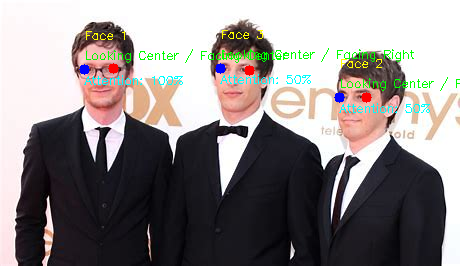


📸 Results for image: billie_group_photo (3).jpg

🧍 Face #1
   ➤ Looking Right / Facing Right
   ➤ Attention Score: 50%



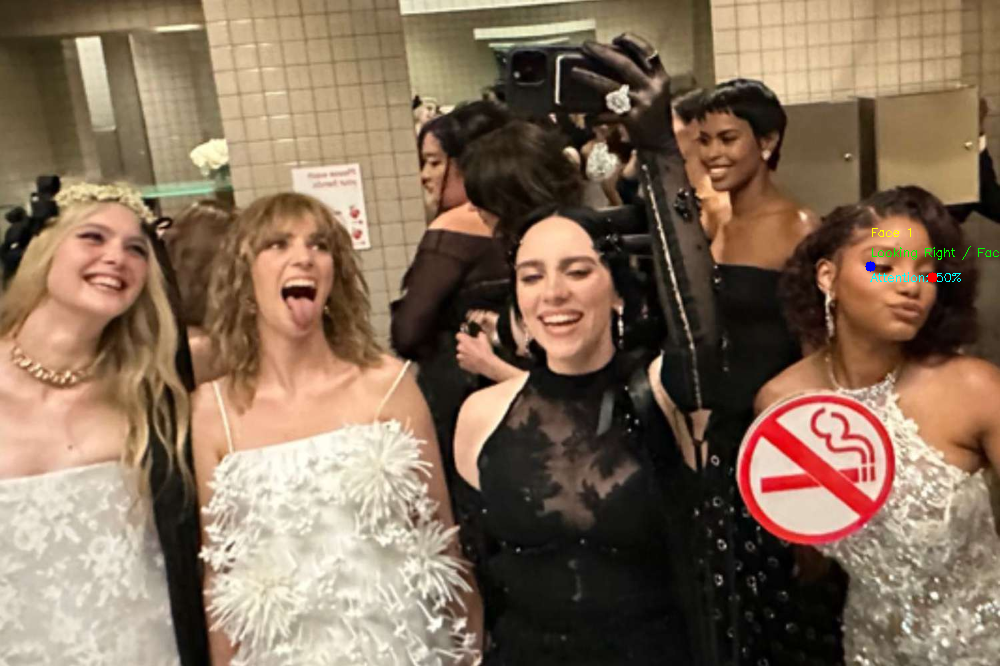


📸 Results for image: group (2).jpg

🧍 Face #1
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%

🧍 Face #2
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%

🧍 Face #3
   ➤ Looking Right / Facing Left
   ➤ Attention Score: 50%

🧍 Face #4
   ➤ Looking Center / Facing Left
   ➤ Attention Score: 50%

🧍 Face #5
   ➤ Looking Center / Facing Right
   ➤ Attention Score: 50%



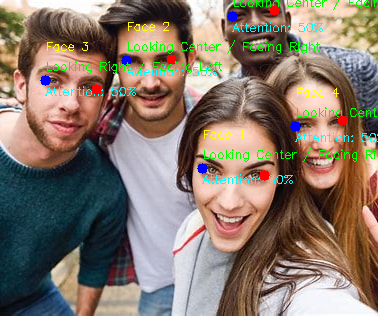

In [ ]:
# Install dependencies
# !pip install opencv-python-headless==4.7.0.72 mediapipe --quiet

import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload image(s)
uploaded = files.upload()

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True, max_num_faces=10)

# Landmark indices
LEFT_EYE_IDX = 33
RIGHT_EYE_IDX = 263
NOSE_TIP_IDX = 1
CHIN_IDX = 152
LEFT_MOUTH_IDX = 61
RIGHT_MOUTH_IDX = 291

# Helper functions
def get_landmark_coords(landmarks, shape):
    h, w, _ = shape
    return [(int(pt.x * w), int(pt.y * h)) for pt in landmarks]

def compute_head_pose(landmarks, shape):
    image_points = np.array([
        get_landmark_coords([landmarks[NOSE_TIP_IDX]], shape)[0],
        get_landmark_coords([landmarks[CHIN_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0],
        get_landmark_coords([landmarks[LEFT_MOUTH_IDX]], shape)[0],
        get_landmark_coords([landmarks[RIGHT_MOUTH_IDX]], shape)[0],
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),
        (0.0, -63.6, -12.5),
        (-43.3, 32.7, -26),
        (43.3, 32.7, -26),
        (-28.9, -28.9, -24.1),
        (28.9, -28.9, -24.1)
    ])

    focal_length = shape[1]
    center = (shape[1] / 2, shape[0] / 2)
    camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
    ], dtype="double")

    dist_coeffs = np.zeros((4, 1))
    success, rot_vec, trans_vec = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    return rot_vec, trans_vec

def get_gaze_direction(left_eye, right_eye):
    eye_vector = np.array(right_eye) - np.array(left_eye)
    angle = np.arctan2(eye_vector[1], eye_vector[0]) * 180 / np.pi
    return angle

def detailed_gaze_description(yaw, eye_angle):
    head = "Facing Center"
    eyes = "Looking Center"
    if yaw < -10: head = "Facing Left"
    elif yaw > 10: head = "Facing Right"
    if eye_angle < -10: eyes = "Looking Left"
    elif eye_angle > 10: eyes = "Looking Right"
    return f"{eyes} / {head}"

def calculate_attention_score(yaw, eye_angle):
    yaw_abs = abs(yaw)
    eye_abs = abs(eye_angle)
    if yaw_abs < 10 and eye_abs < 10:
        return 100
    elif yaw_abs < 10 and eye_abs < 20:
        return 75
    elif yaw_abs < 20 or eye_abs < 20:
        return 50
    else:
        return 25

# Process each uploaded image
for image_name in uploaded:
    image = cv2.imread(image_name)

    if image.shape[1] > 1000:
        image = cv2.resize(image, (1000, int(image.shape[0] * 1000 / image.shape[1])))

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        shape = image.shape
        print(f"\n📸 Results for image: {image_name}\n")

        for i, face_landmarks in enumerate(results.multi_face_landmarks):
            landmarks = face_landmarks.landmark

            # Head pose
            rot_vec, _ = compute_head_pose(landmarks, shape)
            rot_matrix, _ = cv2.Rodrigues(rot_vec)
            angles, _, _, _, _, _ = cv2.RQDecomp3x3(rot_matrix)
            yaw = angles[1]

            # Eye positions
            left_eye = get_landmark_coords([landmarks[LEFT_EYE_IDX]], shape)[0]
            right_eye = get_landmark_coords([landmarks[RIGHT_EYE_IDX]], shape)[0]
            eye_angle = get_gaze_direction(left_eye, right_eye)

            # Label & score
            gaze_label = detailed_gaze_description(yaw, eye_angle)
            attention_score = calculate_attention_score(yaw, eye_angle)

            # Print conclusion
            print(f"🧍 Face #{i + 1}")
            print(f"   ➤ {gaze_label}")
            print(f"   ➤ Attention Score: {attention_score}%\n")

            # Draw landmarks and labels
            cv2.putText(image, f"Face {i+1}", (left_eye[0], left_eye[1] - 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
            cv2.putText(image, gaze_label, (left_eye[0], left_eye[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
            cv2.putText(image, f"Attention: {attention_score}%", (left_eye[0], left_eye[1] + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)

            cv2.circle(image, left_eye, 5, (255, 0, 0), -1)
            cv2.circle(image, right_eye, 5, (0, 0, 255), -1)

        # Display the result
        cv2_imshow(image)
    else:
        print(f"No face detected in image: {image_name}")
